### Loading data and libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model, preprocessing, model_selection,feature_extraction

In [2]:
from sklearn.model_selection import RandomizedSearchCV

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from nlp_utils.model import train_model

In [6]:
data_folder = 'data/'

In [7]:
## using the cleaned files
train_data = pd.read_csv(data_folder+'train_clean.csv'); print(train_data.shape)
test_data = pd.read_csv(data_folder+'test_clean.csv'); print(test_data.shape)

(7613, 6)
(3263, 5)


In [8]:
train_data.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cali...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [9]:
train_data[train_data['target'] == 1].sample()['text'].values[0]

"@GrabakaHitman @Izi_Garcia when he flattened machida...did he lose that fight..nope he lost fights to guys he shouldn't of lost to also"

In [10]:
# train_data.location.value_counts()

In [11]:
sample_submission = pd.read_csv(data_folder+'sample_submission.csv')
# sample_submission.head()

### Train test split

In [12]:
train_x,valid_x, train_y, valid_y = model_selection.train_test_split(train_data['text'], train_data['target'])

In [13]:
print(f"Training data size: {train_x.shape[0]}")
print(f"Validation data size: {valid_x.shape[0]}")
print(f"Test data size: {test_data.shape[0]}")

Training data size: 5709
Validation data size: 1904
Test data size: 3263


### BERT based model

In [14]:
import tensorflow as tf

In [15]:
import tensorflow_hub as hub

In [16]:
import tensorflow_text as text

In [17]:
tf.get_logger().setLevel('ERROR')

In [18]:
# tf.data.AUTOTUNE

In [19]:
# tf.data.experimental.cardinality?

In [20]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

#### Loading the preprocessing model which will turn text to tokens to be used by the BERT model

In [21]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [22]:
## sample testing
test_text =[ "omg! there's fire everywhere!!"]

text_preprocessed = bert_preprocess_model(test_text)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101 18168  2290   999  2045  1005  1055  2543  7249   999   999   102]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


#### Loading BERT model

In [23]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [24]:
## sample testing
bert_results = bert_model(text_preprocessed)
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9827164   0.9941893  -0.48255125  0.2634319   0.85884553  0.98396456
  0.9831798  -0.9429524  -0.24963209 -0.9996503   0.21117002 -0.92734283]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.29343188 -0.17296982 -0.0316413  ...  0.04438315  0.93953955
  -1.3956356 ]
 [ 1.4011068   0.66153824  0.4544033  ... -0.13173501  0.8983846
  -2.4296365 ]
 [ 0.41354096 -0.2971372  -0.8115582  ...  0.24564976  0.17369291
  -1.9111968 ]
 ...
 [ 0.41028795  1.0014596  -0.96071833 ...  0.41373107  0.9444568
  -1.1610655 ]
 [ 0.49722975  0.79427874 -0.7138391  ...  0.3053011   0.7356332
  -1.4952252 ]
 [ 0.74886984 -0.5142647   0.19201648 ...  0.39005172  1.3086926
  -1.4779232 ]]


### Model Training

In [25]:
from tensorflow.keras import layers

In [26]:
from tensorflow.keras import optimizers

In [27]:
from tensorflow.keras import models

In [28]:
def create_bert_classification_model(lr = 0.0001):
    
    input_layer = layers.Input(shape=(), dtype = tf.string, name = 'text')
    
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name = 'preprocessing')
    encoder_inputs = preprocessing_layer(input_layer)
    
    ## setting BERT encoder to an untrainable state
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable = True, name = 'BERT_encoder') 
    encoder_output = encoder(encoder_inputs)
    encoder_output = encoder_output['pooled_output']
    
    output_layer = layers.Dropout(0.1)(encoder_output)
#     output_layer = layers.Dense(16, activation = 'relu', name = 'dense_layer_1')(output_layer)
    output_layer = layers.Dense(1, activation = 'sigmoid')(output_layer)
    
    model = models.Model(input_layer, output_layer)
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=loss, metrics=metrics)
    
    return model
    
    

In [29]:
model = create_bert_classification_model(lr=3e-05)

In [30]:
## testing on sample text
bert_raw_results = model(tf.constant(test_text))
print(tf.sigmoid(bert_raw_results))

tf.Tensor([[0.55913264]], shape=(1, 1), dtype=float32)


In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [32]:
history = train_model(model, train_x, train_y, valid_x, valid_y, 
            neural_network = True, epochs = 5,
            test_vectors = test_data['text'], submissions_data = sample_submission, submissions_file_prefix="bert_submission" 
                     )

Epoch 1/5
179/179 [==============================] - 924s 5s/step - loss: 0.5320 - binary_accuracy: 0.7360 - val_loss: 0.4262 - val_binary_accuracy: 0.8167
Epoch 2/5
179/179 [==============================] - 1077s 6s/step - loss: 0.3606 - binary_accuracy: 0.8530 - val_loss: 0.3933 - val_binary_accuracy: 0.8377
Epoch 3/5
179/179 [==============================] - 1051s 6s/step - loss: 0.2927 - binary_accuracy: 0.8830 - val_loss: 0.4218 - val_binary_accuracy: 0.8256
Epoch 4/5
179/179 [==============================] - 932s 5s/step - loss: 0.2235 - binary_accuracy: 0.9221 - val_loss: 0.5192 - val_binary_accuracy: 0.8120
Epoch 5/5
179/179 [==============================] - 899s 5s/step - loss: 0.1690 - binary_accuracy: 0.9394 - val_loss: 0.6020 - val_binary_accuracy: 0.8046
Classification report : 

              precision    recall  f1-score   support

           1       0.74      0.83      0.78       805
           0       0.86      0.79      0.82      1099

   micro avg       0.80     

#### Plotting

In [33]:
from nlp_utils.plot import plot_metrics

In [34]:
# history.history

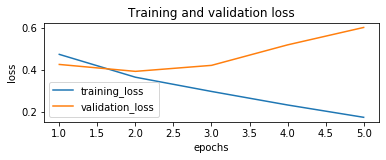

KeyError: 'accuracy'

In [35]:
plot_metrics(history.history)

In [ ]:
plot_metrics?